# Deep Learning for Time Series

### Loading Libraries

In [1]:
# Math Computing
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.utils import load_img, img_to_array

# TensorFlow Datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import imdb
from tensorflow.keras.datasets import reuters
from tensorflow.keras.datasets import boston_housing

# Operating System
import os, shutil, pathlib
import random

### A Temperature-Forecasting example

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-18 11:57:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.196.48, 52.216.177.109, 52.217.117.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.196.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  2.44MB/s    in 10s     

2024-04-18 11:57:15 (1.26 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


##### Inspecting the data of the Jena weather dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


##### Parsing the data

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

##### Plotting the temperature timeseries

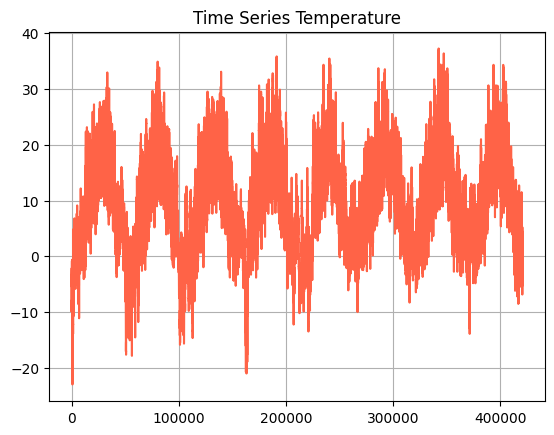

In [7]:
plt.plot(range(len(temperature)), temperature, color='tomato')
plt.title('Time Series Temperature')
plt.grid(True)
plt.show()

##### Plotting the first 10 days of the temperature timeseries

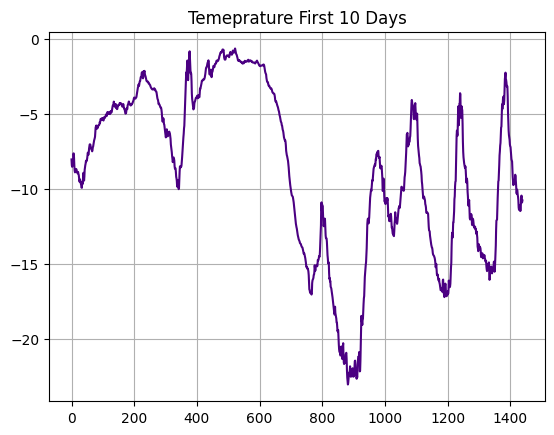

In [10]:
plt.plot(range(1440), temperature[:1440], color='indigo')
plt.title('Temeprature First 10 Days')
plt.grid(True)
plt.show()